# Soft Clustering
## Expectation-Maximization algorithm for Gaussian Mixture model

This is an implementation from scratch of Expectation-Maximization algoirithm for Gaussian Mixture Model. The code below was used to generate the animation of Gaussian Mixture Model converging to the global optimum on a 'mouse dataset'. 

Expectation-Maximization algorithm was used to fit the gaussians to the data.

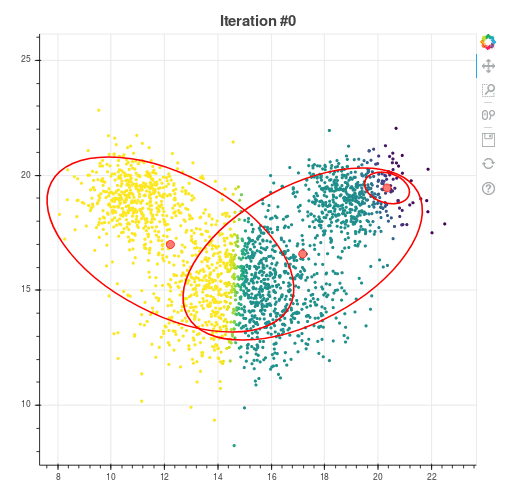

In [88]:
from IPython.display import Image
with open("image/em-gmm4.gif",'rb') as f:
    display(Image(data=f.read(), format='png'))

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
from bokeh.palettes import all_palettes
from bokeh.models import ColumnDataSource
from bokeh.models import LinearColorMapper
from bokeh.palettes import Viridis3, Viridis256
import warnings
warnings.filterwarnings("ignore")
import time
output_notebook()

Loading BokehJS ...

In [8]:
# Read the 'mouse dataset' from csv file
X = np.genfromtxt('data/mouse.csv')

In [61]:
class GaussianMixtureModel:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
    
    def initialize_clusters(self, X):
        '''
        Generate initial clusters parameters (mean, covariance, class priors and weights)
        '''
        indexes = np.random.randint(low=0, high=len(X), size=self.n_clusters)
        self.mu = np.array([X[idx] for idx in indexes])
        self.sigma = [[[1,0], [0,1]] for i in range(self.n_clusters)]
        self.prior = [1/self.n_clusters] * self.n_clusters
        self.weight = np.zeros((len(X), self.n_clusters))
        self.proba = np.zeros((len(X), self.n_clusters))
        self.n_points = np.zeros(self.n_clusters)
        self.init_iter = 0
        self.create(X, i=0)
    
    def loss_function(self):
        return -np.sum(self.weight)
    
    def _expectation(self, X):
        '''
        Expectation step - calculate probability of a point belonging to a given gaussian
        ''' 
        self.log_loss = 0
        for k in range(self.n_clusters):
            
            likelihood = multivariate_normal.pdf(X, mean=self.mu[k], cov=self.sigma[k])
            self.weight[:, k] = self.prior[k] * likelihood
                 
        self.proba = (self.weight.T / np.sum(self.weight, axis=1)).T
    
    def _maximization(self, X):
        '''
        Maximixation step - fit Gaussians using Maximum Likelihood Estimation
        '''
        for k in range(self.n_clusters):
            
            self.n_points[k] = np.sum(self.proba[:, k], axis=0)
            self.mu[k] = np.dot(self.proba[:,k], X) / self.n_points[k]
            self.prior[k] = self.n_points[k] / X.shape[0]
            
            self.sigma[k] = np.dot((self.proba[:,k].reshape(-1, 1)*(X - self.mu[k])).T,
                                                                       (X - self.mu[k]))
            self.sigma[k] /= self.n_points[k]
    
    def fit(self, X):
        '''
        Perform Expectation-Maximization algorithm to fit Gaussians
        '''
        # time.sleep(10)
        delta = 2
        i = 0
        while delta > .00001: 
            
            cost_prev = self.loss_function()
            
            self._expectation(X)
            self._maximization(X)

            i += 1
            self.update(X, i=i)
            
            cost_curr = self.loss_function()
            delta = np.abs((cost_curr-cost_prev)/cost_prev)                   
            
    
    def _get_elipses(self):
        '''
        Get shape and orientation of elipses representing Gaussians
        '''
        s00 = [g[0,0]*2 for g in np.array(em_gmm.sigma)]
        s11 = [g[1,1]*2 for g in np.array(em_gmm.sigma)]
        v = [np.linalg.eig(g)[1] for g in self.sigma]
        angle = [np.arctan(vi[0,0]/vi[1,0]) if vi[1,0] != 0 else 0.5*np.pi for vi in v]
        return s00, s11, angle
    
    def _assign_cluster(self, X):
        '''
        Append a label to each point to indicate its most probable class (needed to map colors)
        '''
        cl = np.arange(self.n_clusters)
        return np.column_stack((X, self.proba.dot(cl)))
    
    def create(self, X, i):
        '''
        Create Bokeh plot
        '''
        self.plot = figure(x_range=(6, 24), y_range=((8, 24)))
        self.plot.title.text = "Iteration #%d, Cost = %.2f " %(i, self.loss_function())
        self.plot.title.text_font_size = '14pt'
        self.plot.title.align = 'center'
        
        Xw = self._assign_cluster(X)
        self.source_xyc  = ColumnDataSource(pd.DataFrame(Xw, columns=['x', 'y', 'w']))
        mapper = LinearColorMapper(palette=Viridis256, low=0, high=2)
        self.plot.scatter(x='x', y='y', fill_color={'field': 'w', 'transform': mapper},
                             source=self.source_xyc, line_color=None)
        
        self.source_mu = ColumnDataSource(pd.DataFrame(self.mu, columns=['x', 'y']))
        self.plot.circle(x='x', y='y', source=self.source_mu, fill_color='salmon',
                            line_color='red', size=10, line_width=1, level='overlay')
        
        s00, s11, angle = self._get_elipses()
        self.source_E = ColumnDataSource(dict(x=self.mu[:, 0], y=self.mu[:,1],
                                              w=s00, h=s11, angle=angle))
        
        self.plot.ellipse(x="x", y="y", width="w", height="h", angle='angle',
                            source=self.source_E, fill_color=None,
                            line_color='red', line_width=2)
        self.mapper = mapper
        self.handle = show(self.plot, notebook_handle=True)
        
    def update(self, X, i):
        '''
        Update Bokeh plot
        '''
        self.plot.title.text = "Iteration #%d, Cost = %.2f " %(i, self.loss_function())
        s00, s11, angle = self._get_elipses()
        self.source_E.data = {'x' : self.mu[:,0], 'y' : self.mu[:,1],
                              'w' : s00, 'h' : s11, 'angle' : angle}
        self.source_mu.data = {'x' : self.mu[:,0], 'y' : self.mu[:,1]}
        Xw = self._assign_cluster(X)
        self.source_xyc.data  = {'x' : Xw[:, 0], 'y' : Xw[:, 1], 'w' : Xw[:, 2]}
        push_notebook(handle=self.handle)
    

In [87]:
em_gmm = GaussianMixtureModel(n_clusters=3)
em_gmm.initialize_clusters(X)
em_gmm.fit(X)